In [1]:
#+--------------------------------------------------------------------------------------+
#|                                        Librerías                                     |
#+--------------------------------------------------------------------------------------+
import urllib.request
import os
import zipfile

import matplotlib.image as mpimg
import matplotlib.pyplot as plt


import tensorflow as tf

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


import numpy as np

In [2]:
#+--------------------------------------------------------------------------------------+
#|               Directorio de ubicación de las imágenes de entrenamiento               |
#+--------------------------------------------------------------------------------------+

#Directorio base
base_dir = 'C:/Users/Saul/Desktop/SAUL/INFORMATICA/UBU 4º/2º semestre/TFG/Fotos_Proyecto_Detección_de_Bajas'

train_dir = os.path.join(base_dir, 'Entrenamiento')
validation_dir = os.path.join(base_dir, 'Validacion')

# Directorio con las fotos de gallinas clasificadas
train_alive_dir = os.path.join(train_dir, 'Gallinas_vivas')
train_dead_dir = os.path.join(train_dir, 'Gallinas_muertas')

# Directory with our validation cat/dog pictures
validation_alive_dir = os.path.join(validation_dir, 'Gallinas_vivas')
validation_dead_dir = os.path.join(validation_dir, 'Gallinas_muertas')

In [3]:
#PRUEBA DE IMPRESIÓN DE NOMBRES
train_alive_fnames = os.listdir( train_alive_dir )
train_dead_fnames = os.listdir( train_dead_dir )

print(train_alive_fnames[:10])
print(train_dead_fnames[:10])

['IMG_20211216_100449.jpg', 'IMG_20211216_100506.jpg', 'IMG_20211216_100618.jpg', 'IMG_20211216_100704.jpg', 'IMG_20211216_100712.jpg', 'IMG_20211216_100902.jpg', 'IMG_20211216_100922.jpg', 'IMG_20211216_101049.jpg', 'IMG_20211216_101357.jpg', 'IMG_20211216_101447.jpg']
['IMG-20211123-WA0003.jpg', 'IMG-20211123-WA0004.jpg', 'IMG-20211123-WA0005.jpg', 'IMG-20211201-WA0018.jpg', 'IMG-20211201-WA0019.jpg', 'IMG-20211201-WA0020.jpg', 'IMG-20211201-WA0021.jpg', 'IMG-20211201-WA0022.jpg', 'IMG-20211201-WA0023.jpg', 'IMG-20211201-WA0024.jpg']


In [4]:
#PRUEBA DE NUMERO DE IMAGENES
print('Imágenes totales de gallinas vivas (entrenamiento):', len(os.listdir(      train_alive_dir ) ))
print('Imágenes totales de gallinas muertas (entrenamiento):', len(os.listdir(      train_dead_dir ) ))

print('Imágenes totales de gallinas vivas (validación):', len(os.listdir( validation_alive_dir ) ))
print('Imágenes totales de gallinas muertas (validación):', len(os.listdir( validation_dead_dir ) ))

Imágenes totales de gallinas vivas (entrenamiento): 61
Imágenes totales de gallinas muertas (entrenamiento): 170
Imágenes totales de gallinas vivas (validación): 43
Imágenes totales de gallinas muertas (validación): 151


In [5]:
#PRUEBA DE MUESTRA DE IMAGENES
#Parámetros gráficos
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

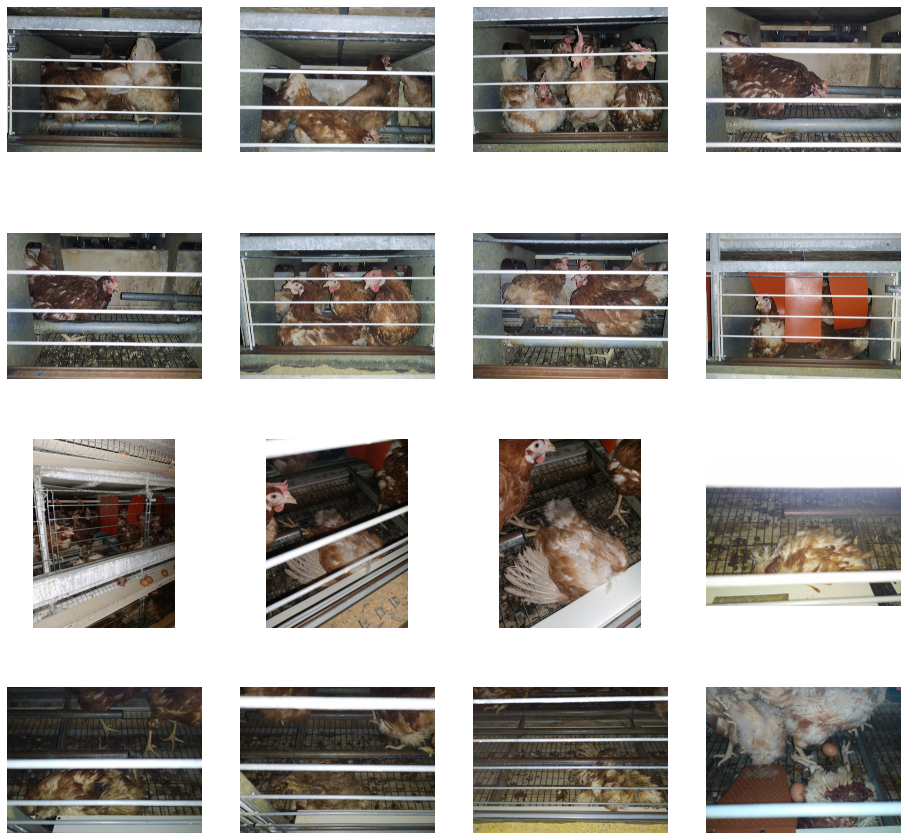

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_alive_pix = [os.path.join(train_alive_dir, fname) 
                for fname in train_alive_fnames[ pic_index-8:pic_index] 
               ]

next_dead_pix = [os.path.join(train_dead_dir, fname) 
                for fname in train_dead_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_alive_pix+next_dead_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [7]:
#PREPROCESAMIENTO DE LOS DATOS

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [9]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [10]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=5,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=5,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 231 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


In [11]:
#ENTRENAMIENTO
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=10,
                              epochs=10,
                              validation_steps=25,
                              verbose=2)

Epoch 1/10
10/10 - 41s - loss: 3.4063 - accuracy: 0.7174 - val_loss: 0.5570 - val_accuracy: 0.7520 - 41s/epoch - 4s/step
Epoch 2/10
10/10 - 39s - loss: 0.6801 - accuracy: 0.5800 - val_loss: 0.6133 - val_accuracy: 0.7760 - 39s/epoch - 4s/step
Epoch 3/10
10/10 - 39s - loss: 0.6076 - accuracy: 0.7600 - val_loss: 0.5271 - val_accuracy: 0.7600 - 39s/epoch - 4s/step
Epoch 4/10
10/10 - 38s - loss: 0.6847 - accuracy: 0.6304 - val_loss: 0.5417 - val_accuracy: 0.7920 - 38s/epoch - 4s/step
Epoch 5/10
10/10 - 39s - loss: 0.6115 - accuracy: 0.7600 - val_loss: 0.4505 - val_accuracy: 0.8080 - 39s/epoch - 4s/step
Epoch 6/10
10/10 - 39s - loss: 0.5986 - accuracy: 0.7000 - val_loss: 0.5782 - val_accuracy: 0.8240 - 39s/epoch - 4s/step
Epoch 7/10
10/10 - 40s - loss: 0.6762 - accuracy: 0.6000 - val_loss: 0.4649 - val_accuracy: 0.8400 - 40s/epoch - 4s/step
Epoch 8/10
10/10 - 41s - loss: 0.6285 - accuracy: 0.8200 - val_loss: 0.6634 - val_accuracy: 0.7600 - 41s/epoch - 4s/step
Epoch 9/10
10/10 - 39s - loss: 0

In [21]:
# PREDECIR IMAGENES
#Directorio que contiene una foto de una gallina, independientemente de su estado, para su clasificación
path='C:/Users/Saul/Desktop/SAUL/INFORMATICA/UBU 4º/2º semestre/TFG/Fotos_Proyecto_Detección_de_Bajas/Prediccion/I_8.jpg'
img=image.load_img(path, target_size=(150, 150))
  
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
  
classes = model.predict(images, batch_size=10)
  
print(classes[0])
  
if classes[0]>0:
    print("Está viva")
    
else:
    print("Está muerta")

[0.]
Está muerta
